In [59]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

from models.unet import UNet
from utils.datasets import OrigaDataset, load_origa
from utils.metrics import *

In [60]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LOAD_MODEL = False
PIN_MEMORY = True if DEVICE == 'cuda' else False
WANDB = False

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cpu


Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


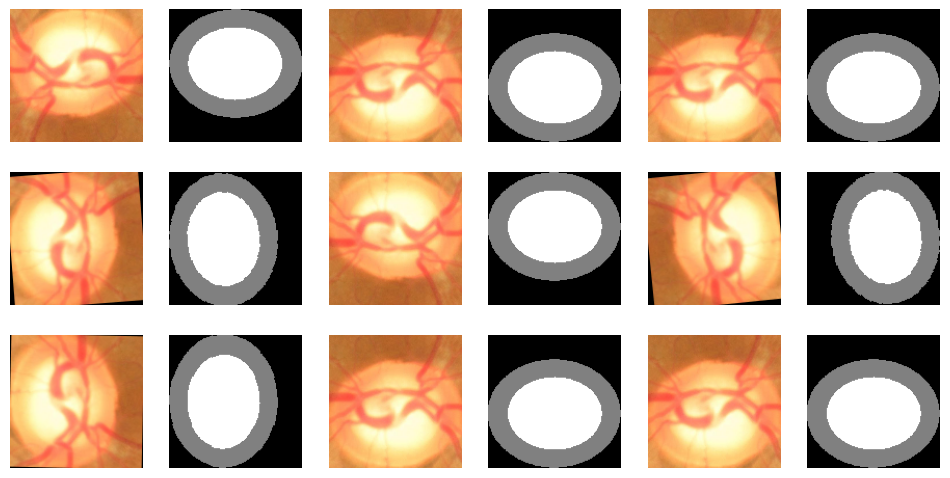

In [61]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    image, mask = next(iter(example_loader))
    image = image.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [62]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Rotate(limit=30, p=0.25, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

train_ds, val_ds, test_ds = load_origa(
    IMAGE_DIR, MASK_DIR, train_transform, val_transform, val_transform,
    # train_size=0.7, val_size=0.15, test_size=0.15,
    train_size=0.01, val_size=0.01, test_size=0.98,
)

print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')
print(f'Test size: {len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Train size: 6
Validation size: 7
Test size: 637


In [63]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


def train(model, criterion, optimizer, epochs, device, train_loader, val_loader=None, scheduler=None):
    history = defaultdict(list)
    train_length, val_length = len(train_loader), len(val_loader)

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:')

        # training
        model.train()
        train_hist = defaultdict(list)
        train_loop = tqdm(train_loader, total=train_length, leave=True)
        train_loop.set_description(f'Training')
        for batch_idx, (images, masks) in enumerate(train_loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # metrics
            preds = torch.argmax(outputs, dim=1)
            epoch_metrics = get_performance_metrics(masks, preds)
            for k, v in epoch_metrics.items():
                train_hist[k].append(v)
            train_hist['loss'].append(loss.item())

            # show summary after last batch
            if batch_idx == train_length - 1:
                # calculate mean metrics over all batches for the current training epoch
                for k, v in train_hist.items():
                    history[f'train_{k}'].append(np.mean(v))
                train_loop.set_postfix(
                    loss=history['train_loss'][-1],
                    acc=history['train_accuracy'][-1],
                    iou=history['train_iou'][-1],
                    dice=history['train_dice'][-1],
                )

        if scheduler is not None:
            scheduler.step(history['train_loss'][-1])

        if val_loader is None:
            continue

        # validation
        model.eval()
        val_hist = defaultdict(list)
        val_loop = tqdm(val_loader, total=val_length, leave=True)
        val_loop.set_description(f'Validation')
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loop):
                images = images.to(device=device)
                masks = masks.to(device=device)

                # forward
                outputs = model(images)
                loss = criterion(outputs, masks.long())

                # metrics
                preds = torch.argmax(outputs, dim=1)
                epoch_metrics = get_performance_metrics(masks, preds)
                for k, v in epoch_metrics.items():
                    val_hist[k].append(v)
                val_hist['loss'].append(loss.item())

                # show summary after last batch
                if batch_idx == val_length - 1:
                    # calculate mean metrics over all batches for the current validation epoch
                    for k, v in val_hist.items():
                        history[f'val_{k}'].append(np.mean(v))
                    val_loop.set_postfix(
                        loss=history['val_loss'][-1],
                        acc=history['val_accuracy'][-1],
                        iou=history['val_iou'][-1],
                        dice=history['val_dice'][-1],
                    )

    return history


In [64]:
model = UNet(in_channels=3, out_channels=3, features=[64, 128, 256, 512]).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

if LOAD_MODEL:
    load_checkpoint(torch.load('checkpoint.pth.tar'), model, optimizer)

In [65]:
hist = train(model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler)

Epoch 1:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it, acc=0.248, dice=0.133, iou=0.0829, loss=1.1]


Epoch 2:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, acc=0.443, dice=0.376, iou=0.265, loss=1.1]


Epoch 3:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.476, dice=0.415, iou=0.278, loss=1.1]


Epoch 4:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it, acc=0.5, dice=0.375, iou=0.258, loss=1.09]


Epoch 5:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s, acc=0.499, dice=0.365, iou=0.254, loss=1.09]


Epoch 6:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s, acc=0.487, dice=0.364, iou=0.252, loss=1.08]


Epoch 7:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, acc=0.478, dice=0.364, iou=0.252, loss=1.08]


Epoch 8:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, acc=0.463, dice=0.362, iou=0.25, loss=1.07]


Epoch 9:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.445, dice=0.356, iou=0.245, loss=1.07]


Epoch 10:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s, acc=0.425, dice=0.342, iou=0.234, loss=1.07]


Epoch 11:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s, acc=0.423, dice=0.337, iou=0.23, loss=1.06]


Epoch 12:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.425, dice=0.337, iou=0.23, loss=1.03]


Epoch 13:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, acc=0.487, dice=0.422, iou=0.29, loss=0.959]


Epoch 14:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.492, dice=0.482, iou=0.324, loss=0.945]


Epoch 15:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, acc=0.511, dice=0.513, iou=0.359, loss=0.969]


Epoch 16:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, acc=0.54, dice=0.537, iou=0.39, loss=1.06]


Epoch 17:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, acc=0.612, dice=0.614, iou=0.463, loss=0.985]


Epoch 18:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, acc=0.733, dice=0.738, iou=0.59, loss=0.689]


Epoch 19:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s, acc=0.801, dice=0.806, iou=0.676, loss=0.581]


Epoch 20:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.798, dice=0.804, iou=0.674, loss=0.574]


Epoch 21:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.819, dice=0.824, iou=0.702, loss=0.524]


Epoch 22:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.822, dice=0.827, iou=0.706, loss=0.497]


Epoch 23:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.82, dice=0.824, iou=0.703, loss=0.5]


Epoch 24:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.831, dice=0.834, iou=0.718, loss=0.477]


Epoch 25:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.825, dice=0.827, iou=0.709, loss=0.492]


Epoch 26:


Training: 100%|██████████| 2/2 [00:05<00:00,  2.56s/it, acc=0.871, dice=0.873, iou=0.777, loss=0.391]


Epoch 00026: reducing learning rate of group 0 to 1.0000e-05.


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s, acc=0.821, dice=0.824, iou=0.704, loss=0.497]


Epoch 27:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.824, dice=0.826, iou=0.708, loss=0.487]


Epoch 28:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.823, dice=0.825, iou=0.707, loss=0.483]


Epoch 29:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it, acc=0.825, dice=0.826, iou=0.708, loss=0.477]


Epoch 30:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, acc=0.827, dice=0.829, iou=0.712, loss=0.469]


Epoch 31:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, acc=0.828, dice=0.83, iou=0.713, loss=0.466]


Epoch 32:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.831, dice=0.833, iou=0.717, loss=0.46]


Epoch 33:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it, acc=0.83, dice=0.832, iou=0.716, loss=0.462]


Epoch 34:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.83, dice=0.832, iou=0.715, loss=0.464]


Epoch 35:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.833, dice=0.835, iou=0.72, loss=0.459]


Epoch 36:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.833, dice=0.835, iou=0.72, loss=0.459]


Epoch 37:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, acc=0.836, dice=0.838, iou=0.724, loss=0.456]


Epoch 38:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.832, dice=0.835, iou=0.719, loss=0.462]


Epoch 39:


Validation: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it, acc=0.829, dice=0.832, iou=0.715, loss=0.467]


Epoch 40:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.831, dice=0.833, iou=0.717, loss=0.464]


Epoch 41:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.83, dice=0.832, iou=0.716, loss=0.465]


Epoch 42:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, acc=0.832, dice=0.834, iou=0.719, loss=0.461]


Epoch 43:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it, acc=0.828, dice=0.831, iou=0.714, loss=0.467]


Epoch 44:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.831, dice=0.833, iou=0.717, loss=0.463]


Epoch 45:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.829, dice=0.832, iou=0.715, loss=0.465]


Epoch 46:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.828, dice=0.83, iou=0.713, loss=0.466]


Epoch 47:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.826, dice=0.828, iou=0.71, loss=0.471]


Epoch 48:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it, acc=0.825, dice=0.827, iou=0.709, loss=0.473]


Epoch 49:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it, acc=0.824, dice=0.826, iou=0.707, loss=0.475]


Epoch 50:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, acc=0.824, dice=0.826, iou=0.707, loss=0.475]


Epoch 51:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.826, dice=0.828, iou=0.709, loss=0.473]


Epoch 52:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=0.827, dice=0.828, iou=0.71, loss=0.473]


Epoch 53:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it, acc=0.826, dice=0.828, iou=0.709, loss=0.473]


Epoch 54:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it, acc=0.827, dice=0.829, iou=0.711, loss=0.473]


Epoch 55:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, acc=0.83, dice=0.832, iou=0.715, loss=0.467]


Epoch 56:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it, acc=0.827, dice=0.828, iou=0.71, loss=0.473]


Epoch 57:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it, acc=0.829, dice=0.83, iou=0.713, loss=0.469]


Epoch 58:


Training: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it, acc=0.908, dice=0.911, iou=0.837, loss=0.312]


Epoch 00058: reducing learning rate of group 0 to 1.0000e-06.


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it, acc=0.828, dice=0.829, iou=0.712, loss=0.468]


Epoch 59:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it, acc=0.83, dice=0.831, iou=0.715, loss=0.465]


Epoch 60:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.829, dice=0.83, iou=0.713, loss=0.468]


Epoch 61:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, acc=0.826, dice=0.827, iou=0.709, loss=0.474]


Epoch 62:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.825, dice=0.826, iou=0.708, loss=0.475]


Epoch 63:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it, acc=0.828, dice=0.829, iou=0.712, loss=0.471]


Epoch 64:


Training: 100%|██████████| 2/2 [00:05<00:00,  2.83s/it, acc=0.895, dice=0.899, iou=0.818, loss=0.329]


Epoch 00064: reducing learning rate of group 0 to 1.0000e-07.


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it, acc=0.829, dice=0.83, iou=0.713, loss=0.469]


Epoch 65:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it, acc=0.83, dice=0.83, iou=0.713, loss=0.469]


Epoch 66:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.83, dice=0.83, iou=0.713, loss=0.469]


Epoch 67:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it, acc=0.828, dice=0.829, iou=0.712, loss=0.472]


Epoch 68:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s, acc=0.828, dice=0.829, iou=0.711, loss=0.473]


Epoch 69:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.826, dice=0.827, iou=0.709, loss=0.474]


Epoch 70:


Training: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it, acc=0.898, dice=0.9, iou=0.821, loss=0.327]


Epoch 00070: reducing learning rate of group 0 to 1.0000e-08.


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s, acc=0.823, dice=0.824, iou=0.704, loss=0.479]


Epoch 71:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.825, dice=0.826, iou=0.707, loss=0.475]


Epoch 72:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.826, dice=0.827, iou=0.709, loss=0.472]


Epoch 73:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it, acc=0.827, dice=0.827, iou=0.709, loss=0.473]


Epoch 74:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.827, dice=0.828, iou=0.71, loss=0.472]


Epoch 75:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, acc=0.826, dice=0.827, iou=0.709, loss=0.474]


Epoch 76:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.828, dice=0.829, iou=0.712, loss=0.469]


Epoch 77:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.828, dice=0.829, iou=0.711, loss=0.471]


Epoch 78:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.826, dice=0.828, iou=0.71, loss=0.475]


Epoch 79:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.826, dice=0.827, iou=0.709, loss=0.475]


Epoch 80:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it, acc=0.829, dice=0.83, iou=0.713, loss=0.467]


Epoch 81:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.829, dice=0.83, iou=0.713, loss=0.468]


Epoch 82:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, acc=0.829, dice=0.83, iou=0.713, loss=0.467]


Epoch 83:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.83, dice=0.83, iou=0.714, loss=0.466]


Epoch 84:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.827, dice=0.828, iou=0.71, loss=0.472]


Epoch 85:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.828, dice=0.829, iou=0.712, loss=0.469]


Epoch 86:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.829, dice=0.83, iou=0.713, loss=0.466]


Epoch 87:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.829, dice=0.831, iou=0.714, loss=0.469]


Epoch 88:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, acc=0.826, dice=0.828, iou=0.71, loss=0.473]


Epoch 89:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, acc=0.828, dice=0.829, iou=0.712, loss=0.47]


Epoch 90:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, acc=0.827, dice=0.828, iou=0.711, loss=0.472]


Epoch 91:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, acc=0.83, dice=0.832, iou=0.715, loss=0.465]


Epoch 92:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, acc=0.829, dice=0.831, iou=0.714, loss=0.467]


Epoch 93:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, acc=0.83, dice=0.831, iou=0.715, loss=0.466]


Epoch 94:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.825, dice=0.827, iou=0.708, loss=0.473]


Epoch 95:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it, acc=0.824, dice=0.825, iou=0.707, loss=0.474]


Epoch 96:


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, acc=0.826, dice=0.826, iou=0.708, loss=0.473]


Epoch 97:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it, acc=0.827, dice=0.827, iou=0.71, loss=0.473]


Epoch 98:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.825, dice=0.826, iou=0.708, loss=0.475]


Epoch 99:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, acc=0.825, dice=0.826, iou=0.708, loss=0.476]


Epoch 100:


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it, acc=0.828, dice=0.829, iou=0.711, loss=0.471]


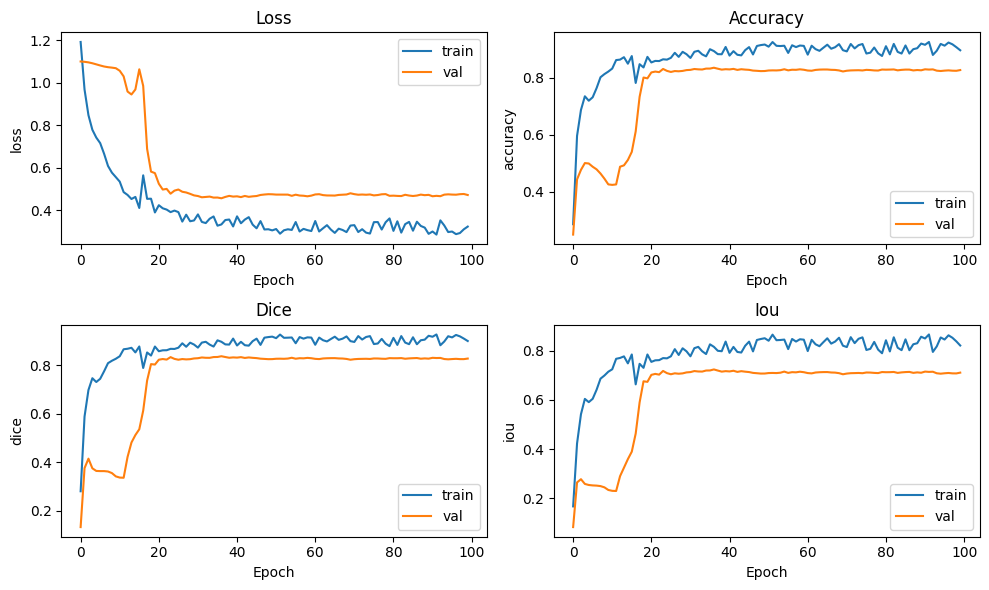

In [66]:
# Plot metrics
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for i, metric in enumerate(['loss', 'accuracy', 'dice', 'iou']):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].legend()
plt.tight_layout()
plt.show()

In [68]:
def evaluate(model, criterion, device, loader):
    model.eval()
    length = len(loader)
    loop = tqdm(loader, total=length, leave=True)
    loop.set_description(f'Evaluating')
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # metrics
            preds = torch.argmax(outputs, dim=1)
            epoch_metrics = get_performance_metrics(masks, preds)
            for k, v in epoch_metrics.items():
                loop.set_postfix({k: v})
            loop.set_postfix(loss=loss.item())

    return epoch_metrics

In [69]:
results = evaluate(model, criterion, DEVICE, test_loader)
results

Evaluating: 100%|██████████| 160/160 [03:20<00:00,  1.26s/it, loss=1]           


{'accuracy': 0.366455078125,
 'precision': 0.6009146743547381,
 'sensitivity': 0.4568732872811972,
 'specificity': 0.74427676,
 'dice': 0.33817540573949173,
 'iou': 0.2596511539109298}

In [67]:
# TODO:
# - Add WandB logging
# - Add model checkpoints
# - Add early stopping